['path3866', 'path3850', 'path4569', 'path4600']
3.395360499999997 96.60463900000002 200.39535999999995 293.6046400000002


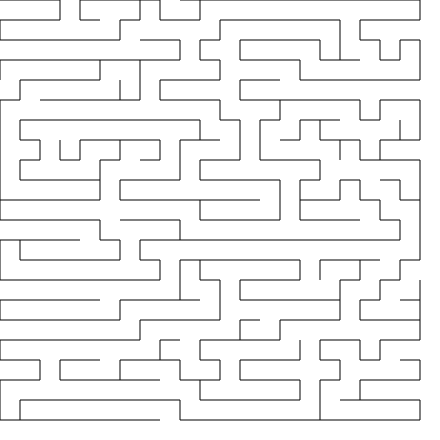

In [1]:
import random
import svgwrite
from svgpathtools import Path, Line, svg2paths, wsvg, path_encloses_pt

random.seed(a = "THIS IS THE GENERATOR STRING", version = 2)

paths, attributes = svg2paths('./bitcoin_coin_plain.svg')

out = 0 + 0j
print([a['id'] for a in attributes])
inner_circle = next(p for p,a in zip(paths, attributes) if a['id'] == 'path4569')
outer_b = next(p for p,a in zip(paths, attributes) if a['id'] == 'path4600')

xmin, xmax, ymin, ymax = inner_circle.bbox()
print(xmin, xmax, ymin, ymax)
pt = ((xmin+xmax)/2) + ((ymin+ymax)/2)*1j

nodes = []

SCALE = 20
SIZE = 22
CONST = (ymax - ymin) / (SIZE / 1.75)
OFFSET = SIZE / 3

svg_document = svgwrite.Drawing(filename = "out.svg", size=(SCALE*SIZE, SCALE*SIZE))

TOP = 1
RIGHT = 2
BOTTOM = 4
LEFT = 8
VISITED = 16

ALL = TOP | RIGHT | BOTTOM | LEFT

matrix = [[(TOP | RIGHT | BOTTOM | LEFT) for _ in range(SIZE)] for _ in range(SIZE)]

def get_coords(x, y, direction):
    if direction == TOP and y > 0:
        return (x, y - 1)
    if direction == BOTTOM and y < SIZE - 1:
        return (x, y + 1)
    if direction == LEFT and x > 0:
        return (x - 1, y)
    if direction == RIGHT and x < SIZE - 1:
        return (x + 1, y)
    
    return None

def is_visited(x, y):
    return matrix[y][x] & VISITED

def opposite(direction):
    if direction == TOP:
        return BOTTOM
    if direction == BOTTOM:
        return TOP
    if direction == LEFT:
        return RIGHT
    if direction == RIGHT:
        return LEFT

def turn_left(direction):
    return LEFT if direction == TOP else (direction >> 1)
    
def turn_right(direction):
    return max(TOP, (direction << 1))
    
def run(x, y, path, prev_pt, drawing=False):    
    if matrix[y][x] & VISITED:
        return False
    
    matrix[y][x] |= VISITED
    
    options = [TOP, RIGHT, RIGHT, RIGHT, BOTTOM, LEFT, LEFT, LEFT]
    random.shuffle(options)
    
    this_pt = xmin + (x - OFFSET)*CONST + 1j * ((y - OFFSET) * CONST + ymin)
    this_line = Line(prev_pt, this_pt)
    draw_this = path_encloses_pt(this_pt, out, inner_circle) and not path_encloses_pt(this_pt, out, outer_b)
    if not draw_this and drawing:
        # close the line before us
        (t1, t2) = inner_circle.intersect(this_line, justonemode=True) or outer_b.intersect(this_line, justonemode=True)
        paths.append(Path(Line(prev_pt, this_line.point(t2[0]))))
    elif not drawing and draw_this:
        # new line
        (t1, t2) = inner_circle.intersect(this_line, justonemode=True) or outer_b.intersect(this_line, justonemode=True)
        paths.append(Path(Line(this_pt, this_line.point(t2[0]))))
    elif drawing:
        paths.append(this_line)
        
    path.push('L{},{}'.format(x * SCALE, y * SCALE))
    
    for opt in options:
        # already no wall
        if (matrix[y][x] & opt) == 0:
            continue
        
        coords = get_coords(x, y, opt)
        if coords is None:
            continue
        x1, y1 = coords
        
        if is_visited(x1, y1):
            continue
        
        matrix[y][x] ^= opt
        matrix[y1][x1] ^= opposite(opt)
        
        path.push('M{},{}'.format(x * SCALE, y * SCALE))
        run(x1, y1, path, this_pt, draw_this)
        path.push('Z')
        
path = svg_document.path('M0,0 ', stroke_width=1, stroke='black', fill='none')
run(0, 0, path, 0+0j)
path.push('Z')

svg_document.add(path)
svg_document.save()

wsvg(paths, nodes=nodes, filename='out-masked.svg')

from IPython.display import SVG
SVG(data=svg_document.tostring())